In [1]:
%load_ext autoreload
%autoreload 2

### Setup

In [2]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from utils import DATA_DIR, ROOT_DIR, PLOT_DIR
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from dataloader import get_nd_array, get_slice
from download.hf import pull_predictions_from_hf

import metaanalysis
plt.close()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)  # ignore fitting warnings

### Load Data

In [3]:
local_path = f'{DATA_DIR}/data/benchmarks-00000-of-00001.parquet'
df_benchmarks = pd.read_parquet(local_path)
print(f'Loaded {len(df_benchmarks):,} model evaluations')

Loaded 810,570 model evaluations


In [4]:
benchmark_tasks = set(df_benchmarks['task'].unique())
TASKS = sorted(list(benchmark_tasks))

In [ ]:
local_path = pull_predictions_from_hf("ANON", "instancesmedium")
COLS = ['step', 'model', 'task', 'mix', 'size', 'token_ratio', 'native_id', 'primary_score', 'acc_per_char', 'logits_per_byte_corr']
df_instances = pd.read_parquet(local_path, columns=COLS)
print(f'Loaded {len(df_instances):,} instance results')

In [5]:
MODELS = df_instances.index.get_level_values('model').unique().to_list()
TASKS  = df_instances.index.get_level_values('task').unique().to_list()
MIXES  = df_instances.index.get_level_values('mix').unique().to_list()

TASKS = sorted(TASKS)

In [5]:
# Get task sets
mmlu      = [t for t in TASKS if 'mmlu' in t and ':' not in t and '_pro_' not in t]
minerva   = [t for t in TASKS if 'minerva' in t and ':' not in t and 'math_500' not in t and t != 'minerva']
mmlu_mc   = [t for t in TASKS if 'mmlu' in t and ':mc' in t and '_pro_' not in t]
olmes     = ['arc_challenge', 'arc_easy', 'boolq', 'csqa', 'hellaswag', 'openbookqa', 'piqa', 'socialiqa', 'winogrande']
olmes_mc  = [f'{task}:mc' for task in olmes]
olmes_gen = ['drop', 'gsm8k', 'jeopardy', 'squad', 'triviaqa']
paloma    = [t for t in TASKS if 'paloma' in t]

selected_tasks = \
    [olmes, minerva, olmes_gen, mmlu] + \
    olmes + \
    olmes_gen + \
    ['mbpp', 'mbppplus', 'codex_humaneval', 'codex_humanevalplus'] + \
    ['autobencher']

### SNR on subsets

In [7]:
from metaanalysis import is_excluded_from_lite
from utils.constants_models import DDOS_MODEL_NAMES

# Get a list of "external models" to train the IRT model
LADDER_MODELS = [model for model in MODELS if 'peteish-moreeval' in model]
external_models = sorted([
    model for model in MODELS 
    if model not in
        DDOS_MODEL_NAMES + # exclude 1B-5xC models
        # LADDER_MODELS + # exclude ladder models
        ['peteish13-highlr'] # exclude intermediate checkpoints from 13B
    and not is_excluded_from_lite(model)
])

# Get a single model to evaluate the training curve
training_curve_model = 'peteish-moreeval-1B-5xC'

In [8]:
task = olmes
metric = 'acc_per_char'
datadecide_1b = [model for model in DDOS_MODEL_NAMES if '1B' in model]

In [9]:
# Get data on all tasks
step_instances, steps, step_scores = \
    get_nd_array(df_instances, 'step', metric, model=training_curve_model, task=task, return_index=True)
datadecide_instances, datadecide_models, datadecide_scores = \
    get_nd_array(df_instances, 'model', metric, model=datadecide_1b, task=task, return_index=True)

In [10]:
from utils import get_title_from_task
from mask_analysis import compute_snr, compute_subtask_snr, get_subtask_utils

snr_by_subtask = compute_subtask_snr(task, step_scores, datadecide_scores, step_instances, datadecide_instances)

for subtask, snr in snr_by_subtask.items():
    print(f"{subtask} SNR\t= {snr:.3f}")

N = 10

get_subtasks, get_subtask, get_subtask_mask = get_subtask_utils(task)

# Get top N subtasks by SNR
top_N_subtasks = sorted(snr_by_subtask.items(), key=lambda x: x[1], reverse=True)[:N]
print("\nTop N subtasks by SNR:")
for subtask, snr in top_N_subtasks:
    print(f"{subtask}: {snr:.3f}")

# Compute combined SNR for top N subtasks
top_N_names = [t[0] for t in top_N_subtasks]
dd_combined_mask = get_subtask_mask(datadecide_instances, top_N_names)
step_combined_mask = get_subtask_mask(step_instances, top_N_names)
snr_orig, rel_std_orig_dd, rel_std_orig_train = compute_snr(
    step_scores, datadecide_scores, step_combined_mask, dd_combined_mask
)

print(f"\nCombined SNR for top N subtasks = {rel_std_orig_dd:.3f}/{rel_std_orig_train:.3f} = {snr_orig:.3f}")

arc_challenge SNR	= 12.395
arc_easy SNR	= 20.471
boolq SNR	= 1.046
csqa SNR	= 7.930
hellaswag SNR	= 11.507
openbookqa SNR	= 2.749
piqa SNR	= 4.253
socialiqa SNR	= 5.261
winogrande SNR	= 4.386

Top N subtasks by SNR:
arc_easy: 20.471
arc_challenge: 12.395
hellaswag: 11.507
csqa: 7.930
socialiqa: 5.261
winogrande: 4.386
piqa: 4.253
openbookqa: 2.749
boolq: 1.046

Combined SNR for top N subtasks = 0.033/0.006 = 5.499


### Load ladder data

In [11]:
from ladder_wrapper import run_ladder, sort_experiment_names
from download.preprocess import is_excluded_from_lite
from utils.constants_models import MODEL_LIST_MIXES
from utils.constants_models import DDOS_MODEL_NAMES

# Train models
all_ladder_models = [model for model in MODELS if 'peteish-moreeval' in model]
all_ladder_models = sort_experiment_names(all_ladder_models)

# Ladder config
ladder_config_path = f'{ROOT_DIR}/analysis/utils/ladder_config.json'

# Eval models
MODEL_LIST_MIXES = [model.split("/")[-1] for model in MODEL_LIST_MIXES]
BROKEN_MODELS = ["gemma-2b", "gemma-7b", "gemma-2-2b", "gemma-2-9b"] # gemma models broken in oe-eval
LLAMA_3_MODELS = [model for model in MODELS if 'Meta-Llama-3' in model]

all_models = sorted([model for model in MODELS if model not in DDOS_MODEL_NAMES + MODEL_LIST_MIXES + BROKEN_MODELS + all_ladder_models])

external_models = [model for model in all_models if not is_excluded_from_lite(model)]

In [ ]:
local_path = pull_predictions_from_hf("ANON", "benchmarks")

df = pd.read_parquet(local_path)
print(f'Loaded {len(df):,} model evaluations')

# fix for the names of one of Ian's data mixes
df.loc[df['mix'] == 'baseline', 'mix'] = 'dolma17'

### Decision Acc / Scaling Law Error

In [ ]:
from mask_analysis import compute_error_by_subtask

cumulative_snrs, decision_accs, prediction_errors, sorted_subtasks = \
        compute_error_by_subtask(df_instances, 'autobencher', metric, all_ladder_models, random_sort=False)

### All 3 Errors on All Tasks

In [ ]:
# tasks = ['autobencher']
tasks = [mmlu, 'autobencher']
# tasks = [olmes, mmlu, 'autobencher']
# tasks = [olmes, mmlu, 'autobencher']

metric = 'acc_per_char'
# metric = 'logits_per_byte_corr'

results = []
for task_name in tasks:
    result = {}

    # Sort by SNR
    cumulative_snrs, decision_accs, prediction_errors, sorted_subtasks = \
        compute_error_by_subtask(df_instances, task_name, metric, all_ladder_models)
    result['snr'] = (cumulative_snrs, decision_accs, prediction_errors, sorted_subtasks)
    
    # Sort randomly
    cumulative_snrs, decision_accs, prediction_errors, sorted_subtasks = \
        compute_error_by_subtask(df_instances, task_name, metric, all_ladder_models, random_sort=True)
    result['random'] = (cumulative_snrs, decision_accs, prediction_errors, sorted_subtasks)

    results += [result]

In [16]:
# Print top SNR subtasks
smooth_subtask = {}
for i, (task, result) in enumerate(zip(tasks, results)):
    (cumulative_snrs, decision_accs, prediction_errors, sorted_subtasks) = result['snr']
    cumulative_snrs = np.mean(np.array(cumulative_snrs), axis=1) # take the 1 of multiple runs
    subtasks = [subtask[0] for subtask in sorted_subtasks][:np.argmax(cumulative_snrs)]
    smooth_subtask[get_title_from_task(task)] = subtasks
display(smooth_subtask)

{'mmlu': ['prehistory',
  'world_religions',
  'high_school_psychology',
  'miscellaneous',
  'conceptual_physics',
  'astronomy',
  'high_school_government_and_politics',
  'college_biology',
  'philosophy',
  'high_school_biology',
  'high_school_microeconomics',
  'anatomy',
  'medical_genetics',
  'logical_fallacies',
  'human_aging'],
 'autobencher': ['science', 'history', 'biology', 'cognitive', 'chemistry']}

In [22]:
import pickle

with open('smooth_subtasks.pkl', 'wb') as f:
    pickle.dump(results, f)

In [6]:
import pickle

with open('smooth_subtasks.pkl', 'rb') as f:
    results = pickle.load(f)
tasks = [mmlu, 'autobencher']

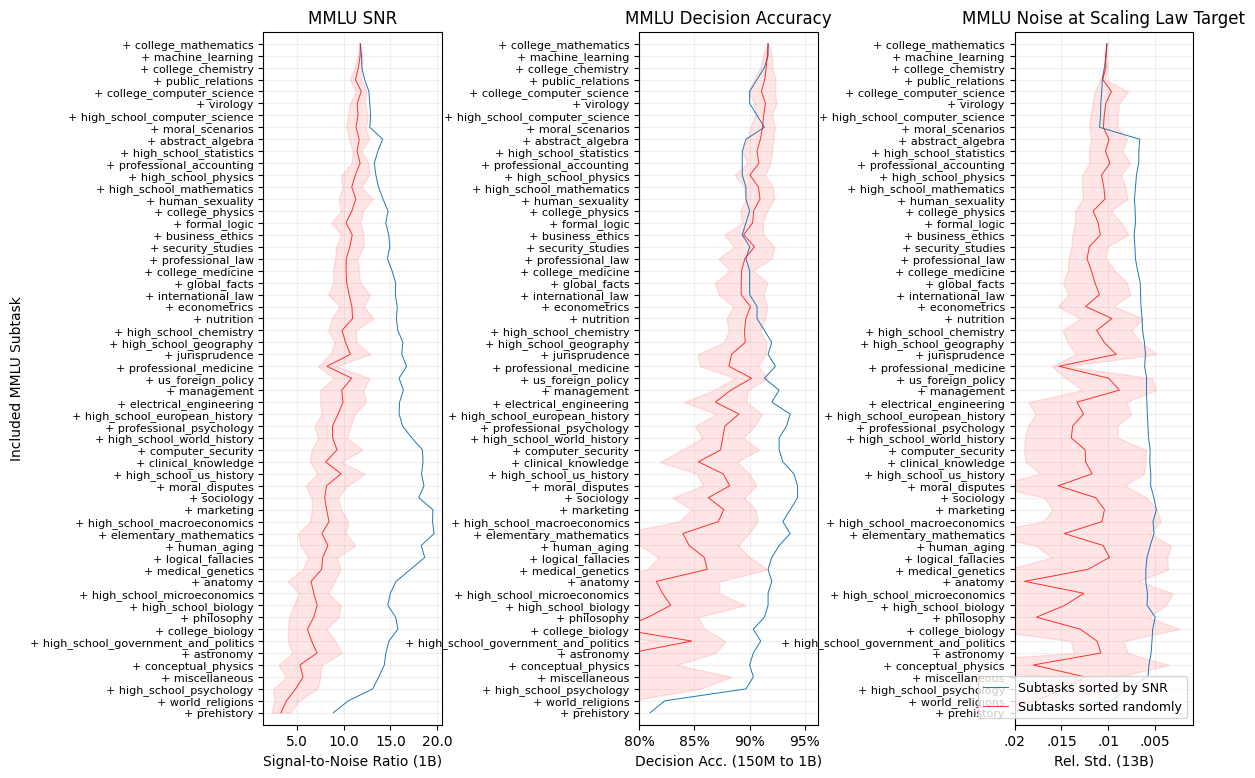

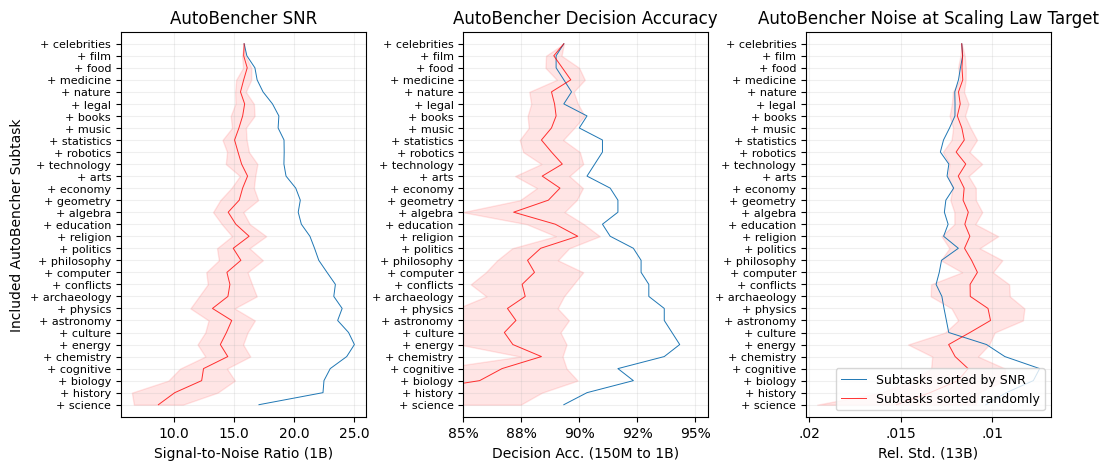

In [50]:
from utils import get_pretty_task_name, get_title_from_task

large_fig = True

for i, (task, result) in enumerate(zip(tasks, results)):
    ax1: plt.Axes
    ax2: plt.Axes
    ax3: plt.Axes
    
    if large_fig:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, (9 if get_title_from_task(task) == 'mmlu' else 5)))
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 2))

    # Plot SNR results
    (cumulative_snrs, decision_accs, prediction_errors, sorted_subtasks) = result['snr']
    cumulative_snrs = np.mean(np.array(cumulative_snrs), axis=1)
    decision_accs = np.mean(np.array(decision_accs), axis=1)
    prediction_errors = np.mean(np.array(prediction_errors), axis=1)

    task_names = [f'+ {subtask}' for subtask, _ in sorted_subtasks]
    y = range(1, len(task_names) + 1)

    if large_fig:
        # Plot with swapped axes
        ax1.plot(cumulative_snrs, y, marker='o', markersize=0, linewidth=0.7)
        ax2.plot(decision_accs, y, marker='o', markersize=0, linewidth=0.7)
        ax3.plot(prediction_errors, y, marker='o', markersize=0, linewidth=0.7, label='Subtasks sorted by SNR')

        # # Add arrow pointing to max SNR
        # max_snr_x = cumulative_snrs[np.argmax(cumulative_snrs)]
        # max_snr_y = np.argmax(cumulative_snrs) + 1
        # min_snr_x = cumulative_snrs[np.argmin(cumulative_snrs)]
        # # Draw text label
        # text_y = max_snr_y - len(cumulative_snrs)/7
        # text_x = max_snr_x - ((max_snr_x-min_snr_x)*0.9)
        # ax1.text(text_x, text_y,
        #         f'Highest signal-to-noise ratio\nis top {int(max_snr_y)} {get_pretty_task_name(task)} subtasks',
        #         fontsize=9)

        # # Draw arrow separately
        # ax1.annotate('', xy=(max_snr_x, max_snr_y),
        #             xytext=(text_x+((max_snr_x-min_snr_x)*0.3), text_y+len(cumulative_snrs)/7),
        #             arrowprops=dict(facecolor='black', shrink=0.05, width=0.5,
        #                           headwidth=3, headlength=4))

        for ax in [ax1, ax2, ax3]:
            # Set ticks for all tasks
            ax.set_yticks(range(1, len(task_names) + 1))
            ax.set_yticklabels(task_names, fontsize=8)


        ax1.set_ylabel(f'Included {get_pretty_task_name(task)} Subtask')

        # Plot random selection results
        (cumulative_snrs, decision_accs, prediction_errors, sorted_subtasks) = result['random']
        cumulative_snrs = np.array(cumulative_snrs)
        decision_accs = np.array(decision_accs)
        prediction_errors = np.array(prediction_errors)
        y = range(1, len(cumulative_snrs) + 1)
        ax1.plot(np.mean(cumulative_snrs, axis=1), y, color='r', linewidth=0.7, alpha=0.8)
        ax2.plot(np.mean(decision_accs, axis=1), y, color='r', linewidth=0.7, alpha=0.8)
        ax3.plot(np.mean(prediction_errors, axis=1), y, color='r', linewidth=0.7, alpha=0.8, label='Subtasks sorted randomly')
        ax1.fill_betweenx(y,
                        np.mean(cumulative_snrs, axis=1) - np.std(cumulative_snrs, axis=1),
                        np.mean(cumulative_snrs, axis=1) + np.std(cumulative_snrs, axis=1),
                        color='r', alpha=0.1)
        ax2.fill_betweenx(y,
                        np.mean(decision_accs, axis=1) - np.std(decision_accs, axis=1),
                        np.mean(decision_accs, axis=1) + np.std(decision_accs, axis=1),
                        color='r', alpha=0.1)
        ax3.fill_betweenx(y,
                        np.mean(prediction_errors, axis=1) - np.std(prediction_errors, axis=1),
                        np.mean(prediction_errors, axis=1) + np.std(prediction_errors, axis=1),
                        color='r', alpha=0.1)

    else:
        # Original horizontal plots
        ax1.plot(range(1, len(cumulative_snrs) + 1), cumulative_snrs, marker='o', markersize=0, linewidth=0.7)
        ax2.plot(range(1, len(decision_accs) + 1), decision_accs, marker='o', markersize=0, linewidth=0.7)
        ax3.plot(range(1, len(prediction_errors) + 1), prediction_errors, marker='o', markersize=0, linewidth=0.7, label='Subtasks sorted by SNR')

        # Add arrow pointing to max SNR
        max_snr_x = np.argmax(cumulative_snrs) + 1
        max_snr_y = cumulative_snrs[np.argmax(cumulative_snrs)]
        min_snr_y = cumulative_snrs[np.argmin(cumulative_snrs)]
        # Draw text label
        text_x = max_snr_x - len(cumulative_snrs)/7
        text_y = max_snr_y - ((max_snr_y-min_snr_y)*0.9)
        ax1.text(text_x, text_y,
                f'Highest signal-to-noise ratio\nis top {max_snr_x} {get_pretty_task_name(task)} subtasks',
                fontsize=9)

        # Draw arrow separately
        ax1.annotate('', xy=(max_snr_x, max_snr_y),
                    xytext=(text_x+len(cumulative_snrs)/7, text_y+((max_snr_y-min_snr_y)*0.3)),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=0.5,
                                  headwidth=3, headlength=4))

        for ax in [ax1, ax2, ax3]:
            # Set ticks for all tasks
            ax.set_xticks(range(1, len(task_names) + 1))
            
            # Only show labels for every 5th task
            labels = [str(i) if i % 5 == 0 or i == 1 else '' for i in range(1, len(task_names) + 1)]
            ax.set_xticklabels(labels)

            ax.set_xlabel(f'Included {get_pretty_task_name(task)} Subtask')

        # Plot random selection results
        (cumulative_snrs, decision_accs, prediction_errors, sorted_subtasks) = result['random']
        cumulative_snrs = np.array(cumulative_snrs)
        decision_accs = np.array(decision_accs)
        prediction_errors = np.array(prediction_errors)
        x = range(1, len(cumulative_snrs) + 1)
        ax1.plot(x, np.mean(cumulative_snrs, axis=1), color='r', linewidth=0.7, alpha=0.8)
        ax2.plot(x, np.mean(decision_accs, axis=1), color='r', linewidth=0.7, alpha=0.8)
        ax3.plot(x, np.mean(prediction_errors, axis=1), color='r', linewidth=0.7, alpha=0.8, label='Subtasks sorted randomly')
        ax1.fill_between(x,
                        np.mean(cumulative_snrs, axis=1) - np.std(cumulative_snrs, axis=1),
                        np.mean(cumulative_snrs, axis=1) + np.std(cumulative_snrs, axis=1),
                        color='r', alpha=0.1)
        ax2.fill_between(x,
                        np.mean(decision_accs, axis=1) - np.std(decision_accs, axis=1),
                        np.mean(decision_accs, axis=1) + np.std(decision_accs, axis=1),
                        color='r', alpha=0.1)
        ax3.fill_between(x,
                        np.mean(prediction_errors, axis=1) - np.std(prediction_errors, axis=1),
                        np.mean(prediction_errors, axis=1) + np.std(prediction_errors, axis=1),
                        color='r', alpha=0.1)

    ax1.set_xlabel('Signal-to-Noise Ratio (1B)')
    ax2.set_xlabel('Decision Acc. (150M to 1B)')
    ax3.set_xlabel(r'Rel. Std. (13B)')
    ax3.invert_xaxis()

    ax1.set_title(f'{get_pretty_task_name(task)} SNR')
    ax2.set_title(f'{get_pretty_task_name(task)} Decision Accuracy')
    ax3.set_title(f'{get_pretty_task_name(task)} Noise at Scaling Law Target')

    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))
    ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2}'.lstrip('0')))

    ax1.grid(True, linestyle='-', alpha=0.2)
    ax2.grid(True, linestyle='-', alpha=0.2)
    ax3.grid(True, linestyle='-', alpha=0.2)

    ax3.legend(loc='lower right', fontsize=9)

    if task == mmlu:
        ax2.set_xlim(left=0.8)
        ax3.set_xlim(left=0.02)
    elif task == 'autobencher':
        ax2.set_xlim(left=0.85)

    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(0, len(task_names) + 1)

    if large_fig:
        plt.subplots_adjust(wspace=(1.1 if get_title_from_task(task) == 'mmlu' else 0.4))
    else:
        plt.subplots_adjust(wspace=0.23)
    plt.savefig(Path(PLOT_DIR) / f'subtasks_large_{get_title_from_task(task)}.pdf', bbox_inches='tight')
    # plt.savefig(Path(PLOT_DIR) / f'subtasks_{get_title_from_task(task)}.pdf', bbox_inches='tight')
    plt.show()

In [9]:
# calculate diff between full set and SNR subset

# calculate diff between random selection at that point and SNR subset

In [21]:
for i, (task, result) in enumerate(zip(tasks, results)):
    print(get_title_from_task(task))

    (cumulative_snrs, decision_accs, prediction_errors, sorted_subtasks) = result['snr']
    cumulative_snrs   = np.mean(cumulative_snrs, axis=1)
    decision_accs     = np.mean(decision_accs, axis=1)
    prediction_errors = np.mean(prediction_errors, axis=1)
    
    max_snr_x = np.argmax(cumulative_snrs)
    max_snr_y = cumulative_snrs[max_snr_x]
    max_acc_x = np.argmax(decision_accs) 
    max_acc_y = decision_accs[max_acc_x]

    (rand_cumulative_snrs, rand_decision_accs, rand_prediction_errors, rand_sorted_subtasks) = result['random']
    rand_cumulative_snrs   = np.mean(rand_cumulative_snrs, axis=1)
    rand_decision_accs     = np.mean(rand_decision_accs, axis=1)
    rand_prediction_errors = np.mean(rand_prediction_errors, axis=1)

    rand_snr_at_max = rand_cumulative_snrs[max_snr_x]
    rand_snr_final  = rand_cumulative_snrs[-1]
    rand_acc_at_max = rand_decision_accs[max_acc_x]
    rand_acc_final  = rand_decision_accs[-1]

    print(max_snr_y)
    print(rand_snr_at_max)
    print(rand_snr_final)
    print('snr improvement: ' + str(max_snr_y - rand_snr_final))
    print(max_acc_y)
    print(rand_acc_at_max) 
    print(rand_acc_final)
    print('decision acc improvement: ' + str(max_acc_y - rand_acc_final))

mmlu
19.69706016967296
7.650535674944661
11.76096841681381
snr improvement: 7.936091752859149
0.9433333333333334
0.8626666666666667
0.9166666666666666
decision acc improvement: 0.026666666666666727
autobencher
25.001351826138244
13.867345586011828
15.8437104201824
snr improvement: 9.157641405955843
0.9433333333333334
0.8713333333333333
0.8933333333333332
decision acc improvement: 0.050000000000000155
